In [72]:
import pandas as pd
from datetime import datetime
import miceforest as mf
from sklearn.preprocessing import StandardScaler

In [69]:
df = pd.read_csv('../../data/raw/aquifer/auser.csv')

# dates are in format DD/MM/YYYY
# convert to this explicitly
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# most data is missing until 2006, and one feature
# doesn't start until 2007
df = df[df['Date'] > datetime(2007, 4, 5)]

# some features are missing many values, just drop them
df = df.drop([
    'Depth_to_Groundwater_DIEC',
    'Depth_to_Groundwater_PAG',
    'Temperature_Ponte_a_Moriano',
    'Volume_CSA',
    'Volume_CSAL',
    'Hydrometry_Piaggione'
], axis=1)

# some features are using 0 when they actually mean NaN
for c in ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS']:
    df[c] = df[c].replace(0, float('nan'))

# ACEA specified that only the absolute values should be used
for c in df.columns:
    if c == 'Date':
        continue
    df[c] = df[c].abs()

# use multiple imputation to do single imputation
kernel = mf.MultipleImputedKernel(
    data=df.drop('Date', axis=1),
    save_all_iterations=True,
    random_state=143
)
kernel.mice(3, verbose=True)
d = df['Date']
df = kernel.impute_new_data(df.drop('Date', axis=1)).complete_data(0)
df['Date'] = d

Dataset 0
1  | Rainfall_Monte_Serra | Rainfall_Piaggione | Depth_to_Groundwater_LT2 | Depth_to_Groundwater_SAL | Depth_to_Groundwater_CoS | Hydrometry_Monte_S_Quirico
2  | Rainfall_Monte_Serra | Rainfall_Piaggione | Depth_to_Groundwater_LT2 | Depth_to_Groundwater_SAL | Depth_to_Groundwater_CoS | Hydrometry_Monte_S_Quirico
3  | Rainfall_Monte_Serra | Rainfall_Piaggione | Depth_to_Groundwater_LT2 | Depth_to_Groundwater_SAL | Depth_to_Groundwater_CoS | Hydrometry_Monte_S_Quirico
Dataset 1
1  | Rainfall_Monte_Serra | Rainfall_Piaggione | Depth_to_Groundwater_LT2 | Depth_to_Groundwater_SAL | Depth_to_Groundwater_CoS | Hydrometry_Monte_S_Quirico
2  | Rainfall_Monte_Serra | Rainfall_Piaggione | Depth_to_Groundwater_LT2 | Depth_to_Groundwater_SAL | Depth_to_Groundwater_CoS | Hydrometry_Monte_S_Quirico
3  | Rainfall_Monte_Serra | Rainfall_Piaggione | Depth_to_Groundwater_LT2 | Depth_to_Groundwater_SAL | Depth_to_Groundwater_CoS | Hydrometry_Monte_S_Quirico
Dataset 2
1  | Rainfall_Monte_Serra | 

In [70]:
df

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Depth_to_Groundwater_SAL,Depth_to_Groundwater_CoS,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Hydrometry_Monte_S_Quirico,Date
3319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.8,0.0,0.0,...,6.69,4.68,11.80,10.40,13.55,1.085393e+04,16859.09333,13160.806670,0.34,2007-04-06
3320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.71,4.65,12.05,10.50,13.15,1.085393e+04,16859.09333,13160.806670,0.36,2007-04-07
3321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,0.0,...,6.67,4.65,12.30,9.10,14.15,1.031124e+04,16016.13867,12502.766330,0.34,2007-04-08
3322,0.0,0.0,0.0,0.2,0.0,0.0,0.6,1.0,0.0,0.4,...,6.62,4.59,13.15,10.40,14.50,1.085393e+04,16859.09333,13160.806670,0.33,2007-04-09
3323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.64,4.57,12.55,11.50,15.40,1.085393e+04,16859.09333,13160.806670,0.32,2007-04-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.50,5.75,23.20,20.75,23.75,7.189407e+06,7847.90000,9183.433333,0.20,2020-06-26
8150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.50,5.71,23.60,21.35,24.30,7.189407e+06,7847.90000,9183.433333,0.21,2020-06-27
8151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.49,5.73,24.00,21.75,24.55,6.829936e+06,7455.50500,8724.261667,0.23,2020-06-28
8152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.50,5.73,22.40,18.90,23.60,7.189407e+06,7847.90000,9183.433333,0.23,2020-06-29


In [71]:
df.isnull().sum()

Rainfall_Gallicano                         0
Rainfall_Pontetetto                        0
Rainfall_Monte_Serra                       0
Rainfall_Orentano                          0
Rainfall_Borgo_a_Mozzano                   0
Rainfall_Piaggione                         0
Rainfall_Calavorno                         0
Rainfall_Croce_Arcana                      0
Rainfall_Tereglio_Coreglia_Antelminelli    0
Rainfall_Fabbriche_di_Vallico              0
Depth_to_Groundwater_LT2                   0
Depth_to_Groundwater_SAL                   0
Depth_to_Groundwater_CoS                   0
Temperature_Orentano                       0
Temperature_Monte_Serra                    0
Temperature_Lucca_Orto_Botanico            0
Volume_POL                                 0
Volume_CC1                                 0
Volume_CC2                                 0
Hydrometry_Monte_S_Quirico                 0
Date                                       0
dtype: int64

In [73]:
# center & standardize

# we have to picky about the date, which is an invalid data type
sansdate = df.drop('Date', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(sansdate.values)
df2 = pd.DataFrame(X, columns=sansdate.columns)

# add the dates back in
df2['Date'] = df['Date'].reset_index(drop=True)

In [75]:
df2.head()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Depth_to_Groundwater_SAL,Depth_to_Groundwater_CoS,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Hydrometry_Monte_S_Quirico,Date
0,-0.342654,-0.352156,-0.363454,-0.362266,-0.356838,-0.36584,-0.366318,1.506308,-0.375272,-0.361914,...,1.770446,-1.233965,-0.483956,-0.207791,-0.308127,-0.157267,0.470093,1.027522,0.190398,2007-04-06
1,-0.342654,-0.352156,-0.363454,-0.362266,-0.356838,-0.36584,-0.366318,-0.310937,-0.375272,-0.361914,...,1.805032,-1.256491,-0.448005,-0.192165,-0.364750,-0.157267,0.470093,1.027522,0.279059,2007-04-07
2,-0.342654,-0.352156,-0.363454,-0.362266,-0.356838,-0.36584,-0.366318,-0.310937,-0.234549,-0.361914,...,1.735859,-1.256491,-0.412055,-0.410928,-0.223194,-0.157842,-0.081929,0.582723,0.190398,2007-04-08
3,-0.342654,-0.352156,-0.363454,-0.339641,-0.356838,-0.36584,-0.318888,-0.202768,-0.375272,-0.337752,...,1.649393,-1.301542,-0.289822,-0.207791,-0.173649,-0.157267,0.470093,1.027522,0.146067,2007-04-09
4,-0.342654,-0.352156,-0.363454,-0.362266,-0.356838,-0.36584,-0.366318,-0.310937,-0.375272,-0.361914,...,1.683980,-1.316559,-0.376104,-0.035906,-0.046248,-0.157267,0.470093,1.027522,0.101736,2007-04-10


In [76]:
df2.to_csv('../../data/clean/aquifer/auser.csv', index=False)

---

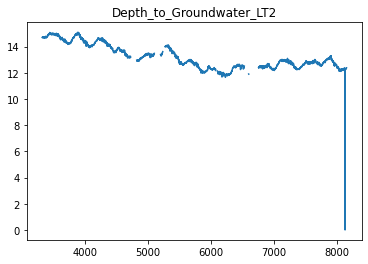

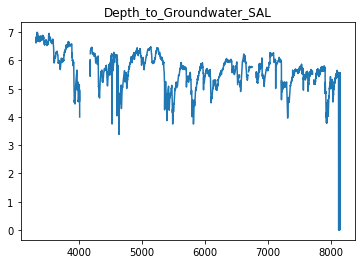

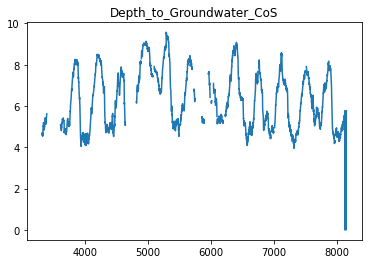

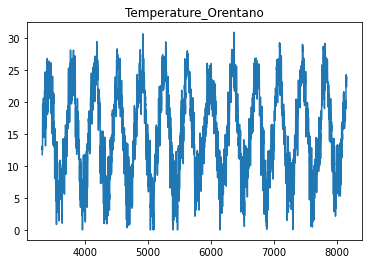

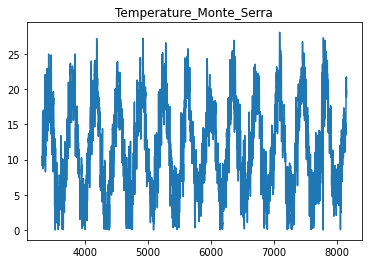

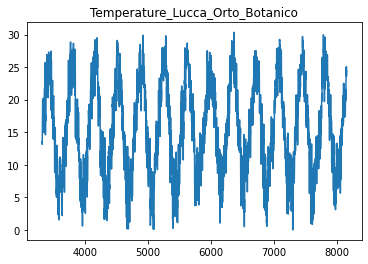

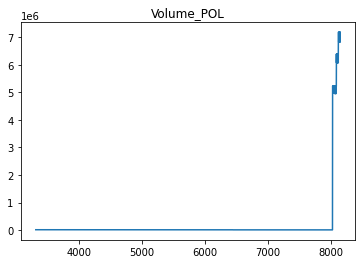

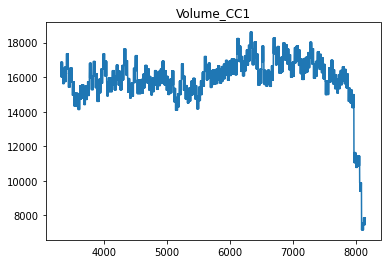

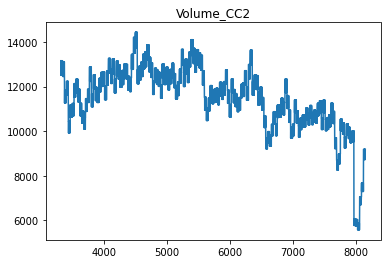

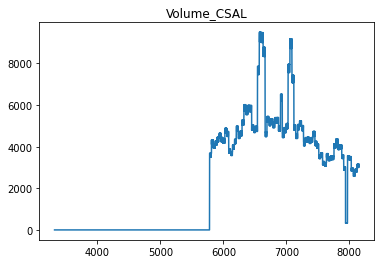

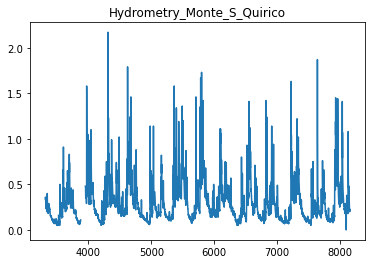

In [63]:
import matplotlib.pyplot as plt
for c in df.columns:
    if c == 'Date' or c.startswith('Rainfall'):
        continue
    plt.plot(df[c])
    plt.title(c)
    plt.show()

In [14]:
df.sort_values('Hydrometry_Monte_S_Quirico', ascending=True).head()

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico
8097,2020-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.75,11.75,0.0,16.15,6.399206e+06,7526.096774,7677.258065,5863.290323,2923.774194,0.00
6364,2015-08-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.40,26.65,29.8,29.70,9.661248e+03,17602.272000,12225.600000,6351.322581,5830.548387,0.05
4204,2009-09-07,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,20.25,16.70,0.0,20.50,1.233438e+04,16689.893330,13148.352000,0.000000,0.000000,0.05
7535,2018-10-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.65,11.95,0.0,17.05,6.957595e+03,14986.987200,10017.864000,5970.259677,3424.627419,0.05
3545,2007-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,6.70,1.90,0.0,5.90,1.083000e+04,14315.056000,11526.540000,0.000000,0.000000,0.05


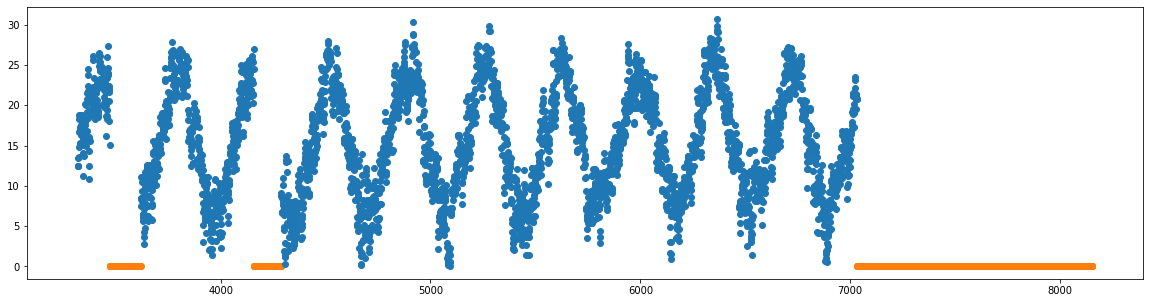

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
iszero = df['Temperature_Ponte_a_Moriano'] == 0
ax.scatter(df[iszero].index, df[iszero]['Temperature_Ponte_a_Moriano'], c='C1')
ax.scatter(df[~iszero].index, df[~iszero]['Temperature_Ponte_a_Moriano'], c='C0')
plt.show()

In [43]:
pd.DataFrame(df['Volume_POL'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Volume_POL,4835.0,159171.561259,943193.594302,4114.6704,7070.112,9467.741935,10552.288,7189406.533


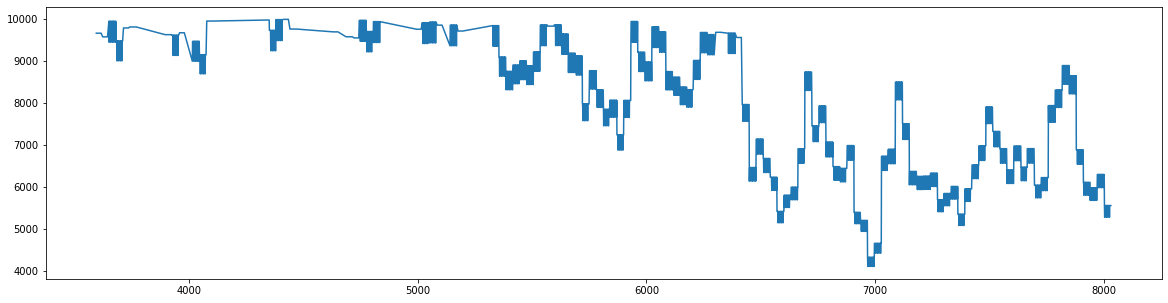

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot(df[df['Volume_POL'] <= 10000]['Volume_POL'])
plt.show()

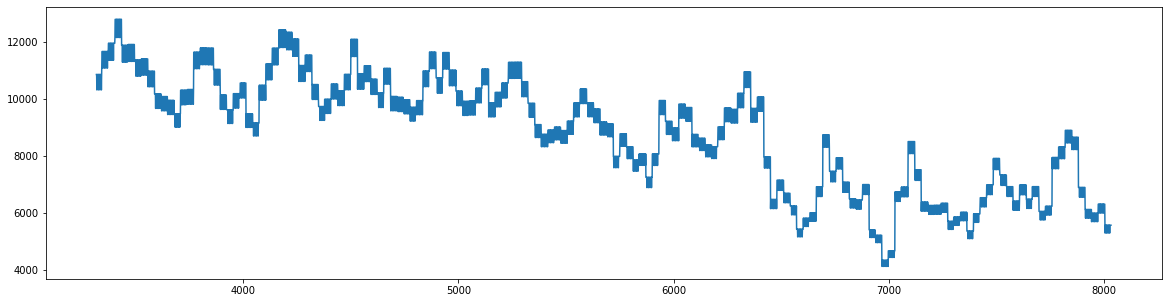

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot(df[df['Volume_POL'] < 100000]['Volume_POL'])
plt.show()

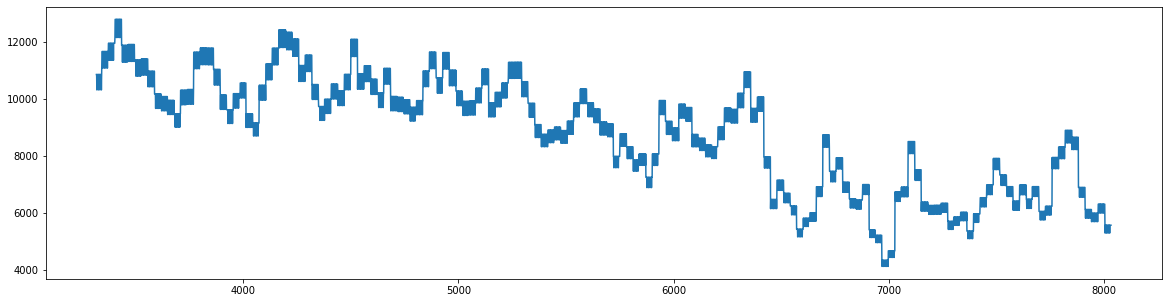

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot(df[df['Volume_POL'] < 1000000]['Volume_POL'])
plt.show()

In [48]:
pd.DataFrame(df[df['Volume_POL'] > 10000]['Volume_POL'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Volume_POL,1769.0,421486.380712,1.524393e+06,10024.6736,10372.53517,11004.65445,11660.6129,7189406.533


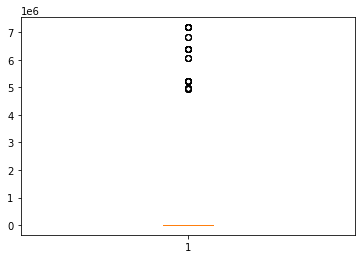

In [52]:
plt.boxplot(df['Volume_POL'])
plt.show()

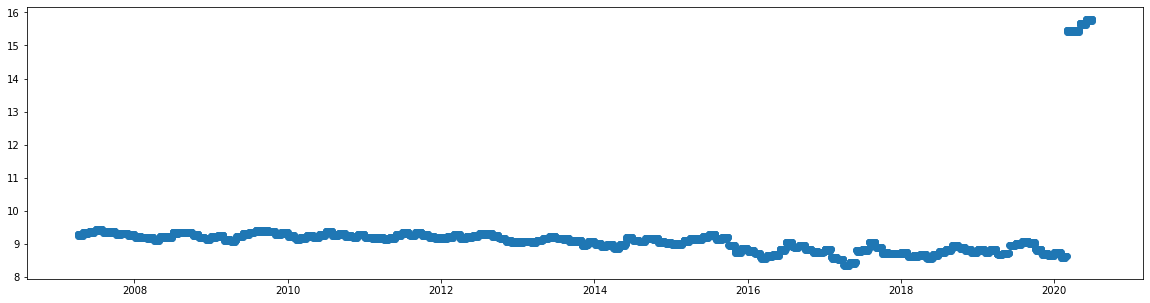

In [54]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.scatter(df['Date'], np.log(df['Volume_POL']))
plt.show()

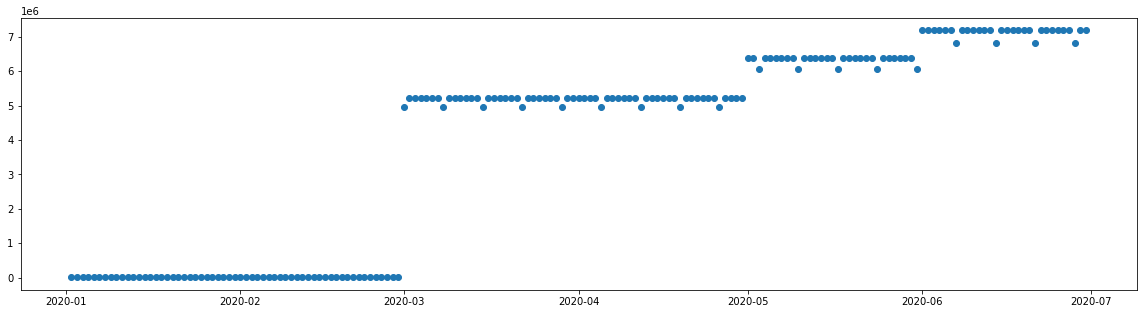

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.scatter(df[df['Date'] > datetime(2020, 1, 1)]['Date'], df[df['Date'] > datetime(2020, 1, 1)]['Volume_POL'])
plt.show()

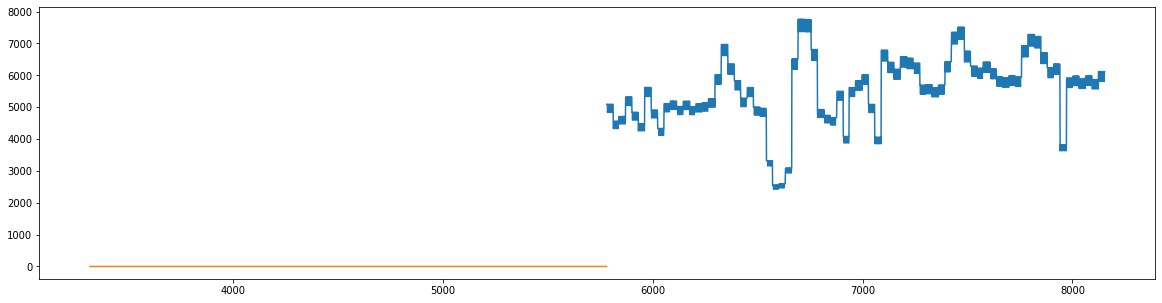

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
iszero = df['Volume_CSA'] == 0
ax.plot(df[iszero]['Volume_CSA'], color='C1')
ax.plot(df[~iszero]['Volume_CSA'], color='C0')
plt.show()

In [59]:
(df['Volume_CSA'] == 0).sum()

2462

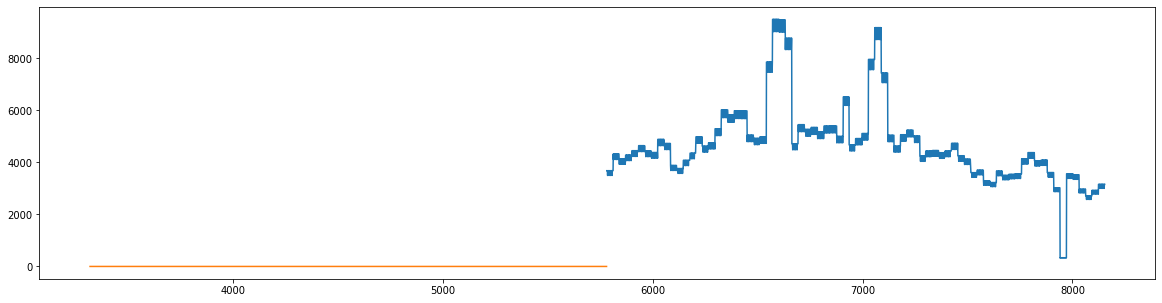

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
iszero = df['Volume_CSAL'] == 0
ax.plot(df[iszero]['Volume_CSAL'], color='C1')
ax.plot(df[~iszero]['Volume_CSAL'], color='C0')
plt.show()